
SORU   | OKUNAN   | DOĞRU    | DURUM       
--------------------------------------------------
1      | B        | B        | ✓ DOĞRU     
2      | C        | C        | ✓ DOĞRU     
3      | E        | E        | ✓ DOĞRU     
4      | A        | A        | ✓ DOĞRU     
5      | A        | A        | ✓ DOĞRU     
6      | D        | D        | ✓ DOĞRU     
7      | B        | B        | ✓ DOĞRU     
8      | C        | C        | ✓ DOĞRU     
9      | C        | C        | ✓ DOĞRU     
10     | E        | E        | ✓ DOĞRU     
11     | A        | A        | ✓ DOĞRU     
12     | E        | E        | ✓ DOĞRU     
13     | D        | D        | ✓ DOĞRU     
14     | D        | D        | ✓ DOĞRU     
15     | D        | D        | ✓ DOĞRU     
16     | B        | B        | ✓ DOĞRU     
17     | C        | C        | ✓ DOĞRU     
18     | A        | A        | ✓ DOĞRU     
19     | E        | E        | ✓ DOĞRU     
20     | E        | E        | ✓ DOĞRU     
------------------------

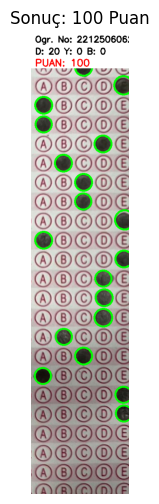

[INFO] Sonuçlar 'Sinav_Sonuclari.xlsx' dosyasına kaydedildi.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Excel için gerekli kütüphane

# ======================================================================
# AYARLAR
# ======================================================================
DOSYA_ADI = "cevap.jpeg"
COZULECEK_SORU_SAYISI = 20
OGRENCI_NO = "2212506062"
SORU_BASI_PUAN = 5

# ======================================================================
# YARDIMCI FONKSİYONLAR
# ======================================================================

def goster(resim, baslik='Görüntü', figsize=(10, 6)):
    plt.figure(figsize=figsize)
    if len(resim.shape) == 3:
        plt.imshow(cv2.cvtColor(resim, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(resim, cmap='gray')
    plt.title(baslik)
    plt.axis('off')
    plt.show()

def dort_kose_bul(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 200)

    cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4 and cv2.contourArea(c) > 10000:
            return approx.reshape(4, 2)
    return None

def perspektif_duzelt(image, pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    (tl, tr, br, bl) = rect
    width = max(int(np.linalg.norm(br - bl)), int(np.linalg.norm(tr - tl)))
    height = max(int(np.linalg.norm(tr - br)), int(np.linalg.norm(tl - bl)))
    
    dst = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (width, height))

def daireleri_bul(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20, param1=50, param2=23, minRadius=8, maxRadius=25)
    return circles

def daireleri_gruplara_ayir(circles, tolerance=20):
    if circles is None: return []
    if isinstance(circles, list): circles = np.array(circles)
    if circles.ndim == 3: circles = circles[0]

    circles = np.round(circles).astype("int")
    circles = sorted(circles, key=lambda c: c[1]) # Y sırala

    rows = []
    current_row = [circles[0]]

    for i in range(1, len(circles)):
        if abs(circles[i][1] - current_row[-1][1]) < tolerance:
            current_row.append(circles[i])
        else:
            current_row = sorted(current_row, key=lambda c: c[0]) # X sırala
            rows.append(current_row)
            current_row = [circles[i]]

    if current_row:
        current_row = sorted(current_row, key=lambda c: c[0])
        rows.append(current_row)
    
    rows = sorted(rows, key=lambda r: r[0][1])
    return rows

# ======================================================================
# ANA FONKSİYON
# ======================================================================

def optik_form_oku(dosya_yolu, dogru_cevaplar):
    img = cv2.imread(dosya_yolu)
    if img is None:
        print("HATA: Resim yüklenemedi!")
        return

    # 1. Görüntü İşleme
    kontur = dort_kose_bul(img)
    warped = perspektif_duzelt(img, kontur) if kontur is not None else img.copy()

    h, w = warped.shape[:2]
    roi_top, roi_bottom = int(h * 0.03), int(h * 0.95)
    roi_left, roi_right = int(w * 0.06), int(w * 0.48)
    sol_sutun = warped[roi_top:roi_bottom, roi_left:roi_right]
    
    gray_roi = cv2.cvtColor(sol_sutun, cv2.COLOR_BGR2GRAY)
    sonuc_img = sol_sutun.copy()

    circles = daireleri_bul(sol_sutun)
    if circles is None: return

    circles_rounded = np.round(circles[0, :]).astype("int")
    rows = daireleri_gruplara_ayir(circles_rounded, tolerance=20)
    harfler = ['A', 'B', 'C', 'D', 'E']

    dogru_sayisi = 0
    yanlis_sayisi = 0
    bos_sayisi = 0

    print(f"\n{'SORU':<6} | {'OKUNAN':<8} | {'DOĞRU':<8} | {'DURUM':<12}")
    print("-" * 50)

    # 2. Değerlendirme Döngüsü
    for soru_idx in range(COZULECEK_SORU_SAYISI):
        okunan_harf = "---"
        durum = "BOŞ"
        bulunan_cevap_idx = -1
        dogru_idx = dogru_cevaplar[soru_idx]
        dogru_harf_str = harfler[dogru_idx]

        if soru_idx < len(rows) and len(rows[soru_idx]) == 5:
            row = rows[soru_idx]
            intensities = []
            for (x, y, r) in row:
                mask = np.zeros(gray_roi.shape, dtype="uint8")
                cv2.circle(mask, (x, y), int(r * 0.75), 255, -1)
                intensities.append(cv2.mean(gray_roi, mask=mask)[0])

            min_val = min(intensities)
            min_idx = intensities.index(min_val)
            sorted_intens = sorted(intensities)
            en_koyu, ikinci_koyu = sorted_intens[0], sorted_intens[1]

            if en_koyu < 175 and (ikinci_koyu - en_koyu) > 15:
                bulunan_cevap_idx = min_idx
                okunan_harf = harfler[bulunan_cevap_idx]
                cv2.circle(sonuc_img, row[bulunan_cevap_idx][:2], row[bulunan_cevap_idx][2], (0, 255, 0), 3)
            elif en_koyu < 175:
                durum = "ÇOKLU"
                for (cx, cy, cr) in row: cv2.circle(sonuc_img, (cx, cy), cr, (0, 0, 255), 2)
            else:
                durum = "BOŞ"

        if bulunan_cevap_idx != -1 and durum != "ÇOKLU":
            if bulunan_cevap_idx == dogru_idx:
                durum = "✓ DOĞRU"
                dogru_sayisi += 1
            else:
                durum = "✗ YANLIŞ"
                yanlis_sayisi += 1
                if soru_idx < len(rows) and len(rows[soru_idx]) == 5:
                     cv2.circle(sonuc_img, rows[soru_idx][dogru_idx][:2], rows[soru_idx][dogru_idx][2], (255, 0, 0), 2)
        elif durum == "BOŞ": bos_sayisi += 1
        elif durum == "ÇOKLU": yanlis_sayisi += 1

        print(f"{soru_idx+1:<6} | {okunan_harf:<8} | {dogru_harf_str:<8} | {durum:<12}")

    # 3. Puan Hesaplama ve Görsel Çıktı
    net = dogru_sayisi - (yanlis_sayisi * 0.25)
    toplam_puan = dogru_sayisi * SORU_BASI_PUAN
    
    print("-" * 50)
    print(f"Öğrenci No : {OGRENCI_NO}")
    print(f"Puan       : {toplam_puan}")
    print(f"Net        : {net:.2f}")

    # Resmin üzerine yazdırma
    bilgi_metni_1 = f"Ogr. No: {OGRENCI_NO}"
    bilgi_metni_2 = f"D: {dogru_sayisi} Y: {yanlis_sayisi} B: {bos_sayisi}"
    bilgi_metni_3 = f"PUAN: {toplam_puan}"

    # Arka plan için siyah bir bant ekle (yazı daha iyi okunsun diye)
    cv2.rectangle(sonuc_img, (0, 0), (sonuc_img.shape[1], 90), (255, 255, 255), -1)
    
    # Yazıları yaz (Kırmızı renk, font büyüklüğü 0.8)
    cv2.putText(sonuc_img, bilgi_metni_1, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.putText(sonuc_img, bilgi_metni_2, (10, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.putText(sonuc_img, bilgi_metni_3, (10, 85), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    # İşlenmiş resmi kaydet
    kayit_adi = f"Sonuc_{OGRENCI_NO}.jpg"
    cv2.imwrite(kayit_adi, sonuc_img)
    print(f"\n[INFO] İşaretlenmiş resim '{kayit_adi}' olarak kaydedildi.")
    goster(sonuc_img, f"Sonuç: {toplam_puan} Puan")

    # 4. Excel'e Aktarma
    data = {
        "Öğrenci No": [OGRENCI_NO],
        "Doğru": [dogru_sayisi],
        "Yanlış": [yanlis_sayisi],
        "Boş": [bos_sayisi],
        "Net": [net],
        "Puan": [toplam_puan]
    }
    
    df = pd.DataFrame(data)
    excel_adi = "Sinav_Sonuclari.xlsx"
    
    # Eğer dosya varsa altına ekle, yoksa yeni oluştur
    try:
        with pd.ExcelWriter(excel_adi, mode='a', if_sheet_exists='overlay', engine='openpyxl') as writer:
             # Eğer başlıklar zaten varsa header=False yapabiliriz, burada basitlik için overwrite modunda gibi davranabilir
             # Ancak append mode 'overlay' ile dikkatli kullanılmalı. 
             # Basit yöntem: Dosya varsa oku, birleştir, kaydet.
             try:
                 mevcut_df = pd.read_excel(excel_adi)
                 yeni_df = pd.concat([mevcut_df, df], ignore_index=True)
                 yeni_df.to_excel(excel_adi, index=False)
             except FileNotFoundError:
                 df.to_excel(excel_adi, index=False)
    except FileNotFoundError:
        df.to_excel(excel_adi, index=False)
    except Exception as e:
        # Alternatif basit kayıt (her seferinde yeni dosya veya üzerine yazma riski olmadan)
        print(f"Excel append hatası, yeni dosya deneniyor: {e}")
        df.to_excel(excel_adi, index=False)

    print(f"[INFO] Sonuçlar '{excel_adi}' dosyasına kaydedildi.")

if __name__ == "__main__":
    cevaplar_harf = ['B','C','E','A','A', 'D','B','C','C','E', 'A','E','D','D','D', 'B','C','A','E','E']
    harf_map = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4}
    cevaplar_idx = [harf_map[h] for h in cevaplar_harf]

    optik_form_oku(DOSYA_ADI, cevaplar_idx)